# Model Preprocessing (XGBoost)
## EV Survey 

In [206]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import numpy as np
#------------------------
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
import shap
#-------------------------
from os import listdir
from os.path import isfile, join
import pprint
import os 
from pathlib import Path

Objective
* Evaluate feature relationships
* Evaluate statistical relationship strengths using Pearson or other method

In [207]:
def seabornhist(size=(10,10), data=None, hue_c=None, x=None):
    fig, ax = plt.subplots(figsize=size)
    ax = sns.histplot(x=x, data= data, hue = hue_c, ax=ax)
    plt.show()
    return

def seaborncount(size=(10,10), data=None, hue_c=None, x=None):
    fig, ax = plt.subplots(figsize=size)
    ax = sns.countplot(x=x, data= data, hue = hue_c, ax=ax)
    plt.show()
    return

In [208]:
#collect info about current working directory and the location of the raw data pickle files

wd = Path(os.getcwd())
parent_dir = wd.parent.absolute()

In [209]:
#Data for the EV survey
filename = "processed_data.pkl"
filepath = f"{wd}\\{filename}"
df = pd.read_pickle(filepath)

In [210]:
df.head()

response_id  months_owned  electric_range discontinuance  surveyed_age  \
0           1.0          24.0            81.0      continued          25.0   
6           7.0          14.0            87.0      continued          35.0   
9          11.0          48.0            84.0   discontinued          55.0   
10         12.0          30.0            81.0      continued          55.0   
11         13.0          31.0            84.0      continued          35.0   

    dist_1  trips_greater_200  safety_satisfaction  comfort_satisfaction  \
0    13.92                0.0                  5.0                   5.0   
6     8.54                0.0                  2.0                   2.0   
9    12.91                0.0                  3.0                   2.0   
10    9.43                0.0                  4.0                   4.0   
11   16.32                0.0                  5.0                   5.0   

    refuel_recharge_satisfaction  ...  highest_charge_used_level 1 & level 2  \
0                            5.0  ...                                      0   
6                            3.0  ...                                      0   
9                            3.0  ...                                      0   
10                           5.0  ...                                      0   
11                           5.0  ...                                      1   

    highest_charge_used_level 1, level 2 & dc fast  \
0                                                0   
6                                                0   
9                                                0   
10                                               0   
11                                               0   

    highest_charge_used_level 2  highest_charge_used_level 2 & dc fast  \
0                             1                                      0   
6                             1                                      0   
9                             0                                      0   
10                            0                                      0   
11                            0                                      0   

    highest_charge_used_no charging  surveyed_gender_decline to state  \
0                                 0                                 0   
6                                 0                                 0   
9                                 1                                 0   
10                                1                                 0   
11                                0                                 0   

    surveyed_gender_female  surveyed_gender_genderqueer/non-binary  \
0                        0                                       0   
6                        0                                       0   
9                        0                                       0   
10                       0                                       0   
11                       0                                       0   

    surveyed_gender_male  surveyed_gender_transfemale/transwoman  
0                      1                                       0  
6                      1                                       0  
9                      1                                       0  
10                     1                                       0  
11                     1                                       0  

[5 rows x 123 columns]

In [211]:
df.columns.to_list()

['response_id',
 'months_owned',
 'electric_range',
 'discontinuance',
 'surveyed_age',
 'dist_1',
 'trips_greater_200',
 'safety_satisfaction',
 'comfort_satisfaction',
 'refuel_recharge_satisfaction',
 'performance_satisfaction',
 'env_impact_satisfaction',
 'purch_price_satisfaction',
 'reliability_satisfaction',
 'range_satisfaction',
 'charge_access_satisfaction',
 'adas_satisfaction',
 'household_income',
 'home_charge_type',
 'work_charge_type',
 'backup_vehicle_mpg',
 'finance_type',
 'model_year_1915',
 'model_year_2001',
 'model_year_2011',
 'model_year_2012',
 'model_year_2013',
 'model_year_2014',
 'model_year_2015',
 'model_year_2016',
 'model_year_2017',
 'model_year_2018',
 'Make_',
 'Make_audi',
 'Make_bmw',
 'Make_cadillac',
 'Make_chevrolet',
 'Make_chevy',
 'Make_fiat',
 'Make_ford',
 'Make_honda',
 'Make_hyundai',
 'Make_kia',
 'Make_mercedes-benz',
 'Make_mitsubishi',
 'Make_nissan',
 'Make_smart',
 'Make_tesla',
 'Make_toyota',
 'Make_volkswagen',
 'Make_volkswago

In [212]:
df_preprocessed = df

In [213]:
df_preprocessed.discontinuance
y = df_preprocessed.discontinuance
y.head()
y.replace({'continued': 1, 'discontinued': 0} , inplace=True)
df_preprocessed.drop(columns = 'discontinuance', inplace=True)
X = df_preprocessed

In [214]:
y

0       1
6       1
9       0
10      1
11      1
       ..
4825    1
4827    1
4829    0
4832    0
4833    1
Name: discontinuance, Length: 1947, dtype: int64

## XGBoost Pipeline

### Resample the minority class (Discontinued) using SMOTE-NC algorithm


In [215]:
X.columns.tolist()

['response_id',
 'months_owned',
 'electric_range',
 'surveyed_age',
 'dist_1',
 'trips_greater_200',
 'safety_satisfaction',
 'comfort_satisfaction',
 'refuel_recharge_satisfaction',
 'performance_satisfaction',
 'env_impact_satisfaction',
 'purch_price_satisfaction',
 'reliability_satisfaction',
 'range_satisfaction',
 'charge_access_satisfaction',
 'adas_satisfaction',
 'household_income',
 'home_charge_type',
 'work_charge_type',
 'backup_vehicle_mpg',
 'finance_type',
 'model_year_1915',
 'model_year_2001',
 'model_year_2011',
 'model_year_2012',
 'model_year_2013',
 'model_year_2014',
 'model_year_2015',
 'model_year_2016',
 'model_year_2017',
 'model_year_2018',
 'Make_',
 'Make_audi',
 'Make_bmw',
 'Make_cadillac',
 'Make_chevrolet',
 'Make_chevy',
 'Make_fiat',
 'Make_ford',
 'Make_honda',
 'Make_hyundai',
 'Make_kia',
 'Make_mercedes-benz',
 'Make_mitsubishi',
 'Make_nissan',
 'Make_smart',
 'Make_tesla',
 'Make_toyota',
 'Make_volkswagen',
 'Make_volkswagon',
 'Make_zero',
 

In [216]:
#SMOTE-NC looks for a mask to indicate which columns are categorical(True) and which are continuous (False)
## Link to Library: https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html

cat_mask =  np.array([True] * len(X.columns))
#Set the continuous variables to False state so the sampler knows how to handle them
cat_mask[0:2] = False
cat_mask

array([False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [217]:
sm = SMOTENC(random_state=42, categorical_features=cat_mask)
X_res, y_res = sm.fit_resample(X, y)

In [218]:
y_res.value_counts()

1    1530
0    1530
Name: discontinuance, dtype: int64

Build the XGBoost pipeline

In [219]:
''' model = make_pipeline(
     RandomUnderSampler(random_state=0),
     XGBClassifier(random_state=0)
 ) '''

' model = make_pipeline(\n     RandomUnderSampler(random_state=0),\n     XGBClassifier(random_state=0)\n ) '

In [220]:
# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.2, random_state=1)

In [221]:
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [222]:
clf = XGBClassifier( n_estimators=200, random_state = 42,use_label_encoder=False, max_depth=4)
clf.fit(X_train_scaled, y_train)
y_pred= clf.predict(X_test_scaled)

[15:33:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [223]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       285
           1       0.87      0.85      0.86       327

    accuracy                           0.85       612
   macro avg       0.85      0.85      0.85       612
weighted avg       0.85      0.85      0.85       612



In [224]:
#take a look at our hyperparameters
print('Parameters currently in use:\n')
print(clf.get_params())

Parameters currently in use:

{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 200, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'use_label_encoder': False}


In [225]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
        }

In [226]:
xgb = XGBClassifier( n_estimators=200, random_state = 42)
XGB_random = RandomizedSearchCV(estimator = xgb, param_distributions = params, n_iter = 250, cv = 5,
                                verbose=2, random_state=42, n_jobs = -1)
XGB_random.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=200,...
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=No

In [250]:
best_random = XGB_random.best_estimator_
best_random

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [228]:
predictions = best_random.predict(X_test_scaled)
score       = best_random.score(X_test_scaled, y_test)
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       285
           1       0.87      0.85      0.86       327

    accuracy                           0.86       612
   macro avg       0.86      0.86      0.86       612
weighted avg       0.86      0.86      0.86       612



30


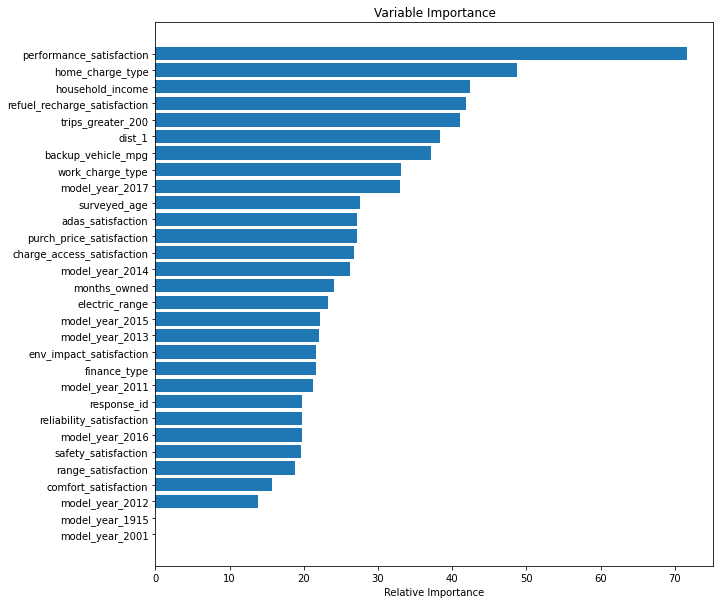

In [229]:
feature_importance = best_random.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [232]:
ground_truth = np.array(y_test)
pred = np.array(predictions)
mapping = {'continued' : 1, 'discontinued' : 0}
ground_truth_mapped = [mapping[zi] for zi in ground_truth]
prediction_mapped = [mapping[zi] for zi in predictions]

KeyError: 1

In [233]:
fpr, tpr, thresholds = roc_curve(prediction_mapped, ground_truth_mapped, pos_label=1)
roc_auc = auc(fpr, tpr)

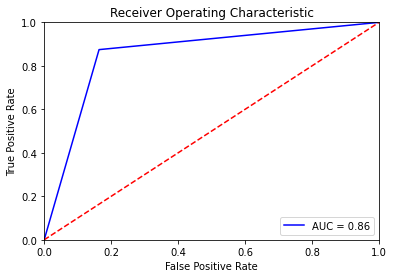

In [234]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Would it be meaningful to predict whether the first time adopters will continue / discontinue?

In [235]:
explainer = shap.Explainer(best_random)

In [236]:
shap_values = explainer(X_train)

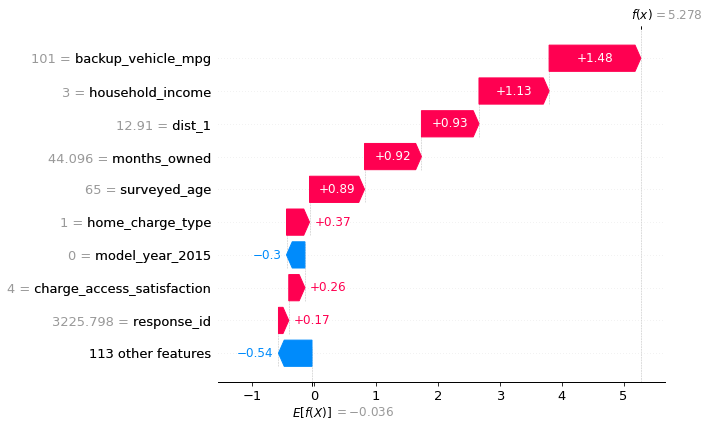

In [237]:
shap.plots.waterfall(shap_values[4])

In [238]:
shap.initjs()
shap.plots.force(shap_values[8])

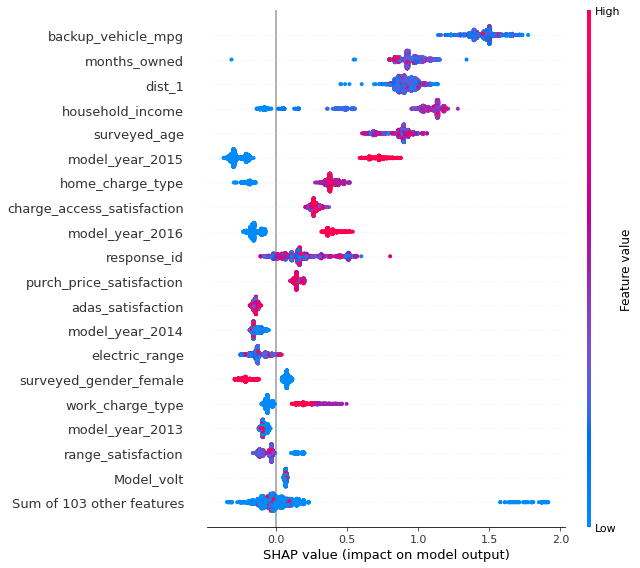

In [239]:
shap.plots.beeswarm(shap_values, max_display=20)

shap.TreeExplainer(best_random).shap_values(X_train) 
shap.summary_plot(shap_values, X_train)

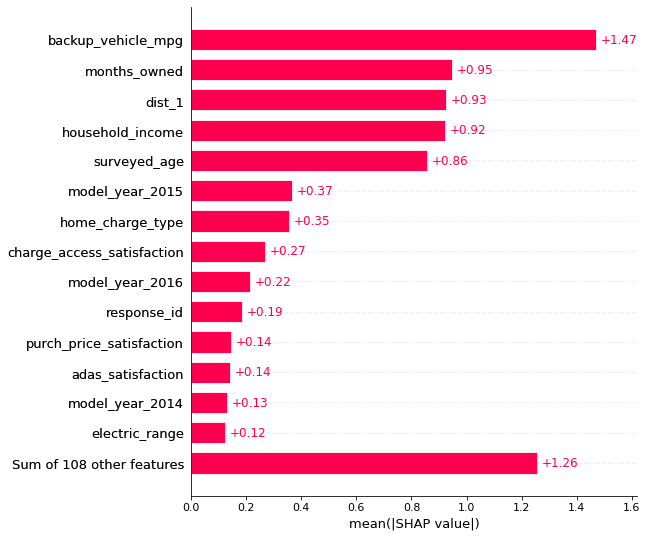

In [240]:
shap.plots.bar(shap_values, max_display=15)

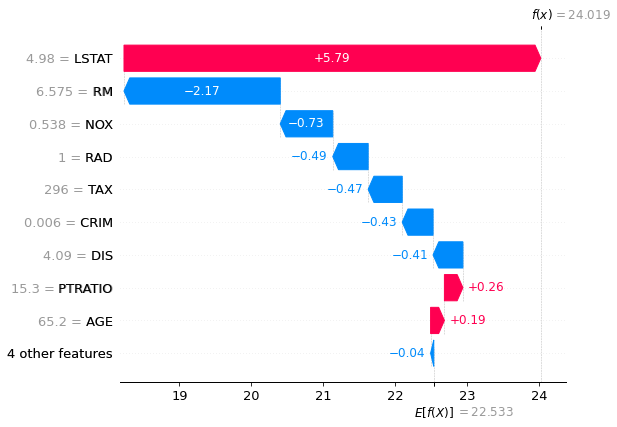

In [241]:
import xgboost
import shap

# train an XGBoost model
X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [231]:
y

0       1
6       1
9       0
10      1
11      1
       ..
4825    1
4827    1
4829    0
4832    0
4833    1
Name: discontinuance, Length: 1947, dtype: int64